In [1]:
import subprocess
import numpy as np
from scipy.interpolate import splev
import matplotlib.pyplot as plt
from synthesizAR.interfaces.ebtel import read_xml,write_xml
from synthesizAR.instruments import InstrumentSDOAIA
import astropy.units as u
import hissw

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [3]:
def run_ebtel(config_filename):
    cmd = subprocess.run(['/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run','-c', config_filename],
                shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE,)
    if cmd.stderr:
        raise ValueError('Ebtel exception')

In [4]:
base_config = read_xml('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')

In [19]:
base_config['output_filename'] = 'tmp'
base_config['c1_cond0'] = 6.0
base_config['loop_length'] = (50.*u.Mm).to(u.cm).value/2.
base_config['total_time'] = (1*u.day).to(u.s).value
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['saturation_limit'] = 1.0/6.0
base_config['heating']['background'] = (1e-7*u.erg/(u.cm**3)/u.s).value
base_config['tau'] = 1
base_config['adaptive_solver_error'] = 1e-6

In [32]:
initial_event = {'event':{'magnitude':(10*u.erg/(u.cm**3)/u.s).value,
                          'rise_start':(10*u.s).value,
                          'rise_end':(10*u.s).value,
                          'decay_start':(210.0 * u.s).value,
                          'decay_end':(210.0 * u.s).value}}

In [36]:
duration_late = np.linspace(200*u.s,1*u.day,5).to(u.s).value
rate_late = (np.linspace(0.01,0.25,5)*u.erg/(u.cm**3)/u.s).value

In [37]:
ssw = hissw.ScriptMaker()
script = """
temperature = {{temperature}}
temperature = temperature / 1.0d6  ;; Units of MK
density = {{density}}

EM = density^(2.0) * {{length}} * 1.0d * {{area}} / 1.0d49  ;; Units of 10^49 cm^-3

goes_fluxes,temperature,EM,goes_long,goes_short,satellite={{goes_number}}
"""

In [38]:
results = {}
for duration in duration_late:
    for rate in rate_late:
        late_event = {'event':{'magnitude':rate,
                               'rise_start':initial_event['event']['decay_end'],
                               'rise_end':initial_event['event']['decay_end'],
                               'decay_start':initial_event['event']['decay_end'],
                               'decay_end':initial_event['event']['decay_end'] + duration}}
        config = base_config.copy()
        config['heating']['events'] = [initial_event,late_event]
        write_xml(config,'tmp.xml')
        run_ebtel('tmp.xml')
        data = np.loadtxt(config['output_filename'])
        responses = {}
        for c in aia.channels:
            responses[c['name']] = ((data[:,3]**2) * splev(data[:,1],c['temperature_response_spline'])
                                    * base_config['loop_length'])
        input_args = {'temperature':data[:,1].tolist(),'density':data[:,3].tolist(),
                      'length':config['loop_length'], 'area': 1e17, 'goes_number':15}
        goes_res = ssw.run(script, args=input_args, save_vars=['goes_long','goes_short'],verbose=False)
        results[f'{duration}_{rate}'] = {**{'t':data[:,0],'Te':data[:,1],'Ti':data[:,2],'n':data[:,3],'q':data[:,-1]},
                                         **responses,**{'goes_long': goes_res['goes_long'],
                                                        'goes_short': goes_res['goes_short']}}

(0, 1.1)

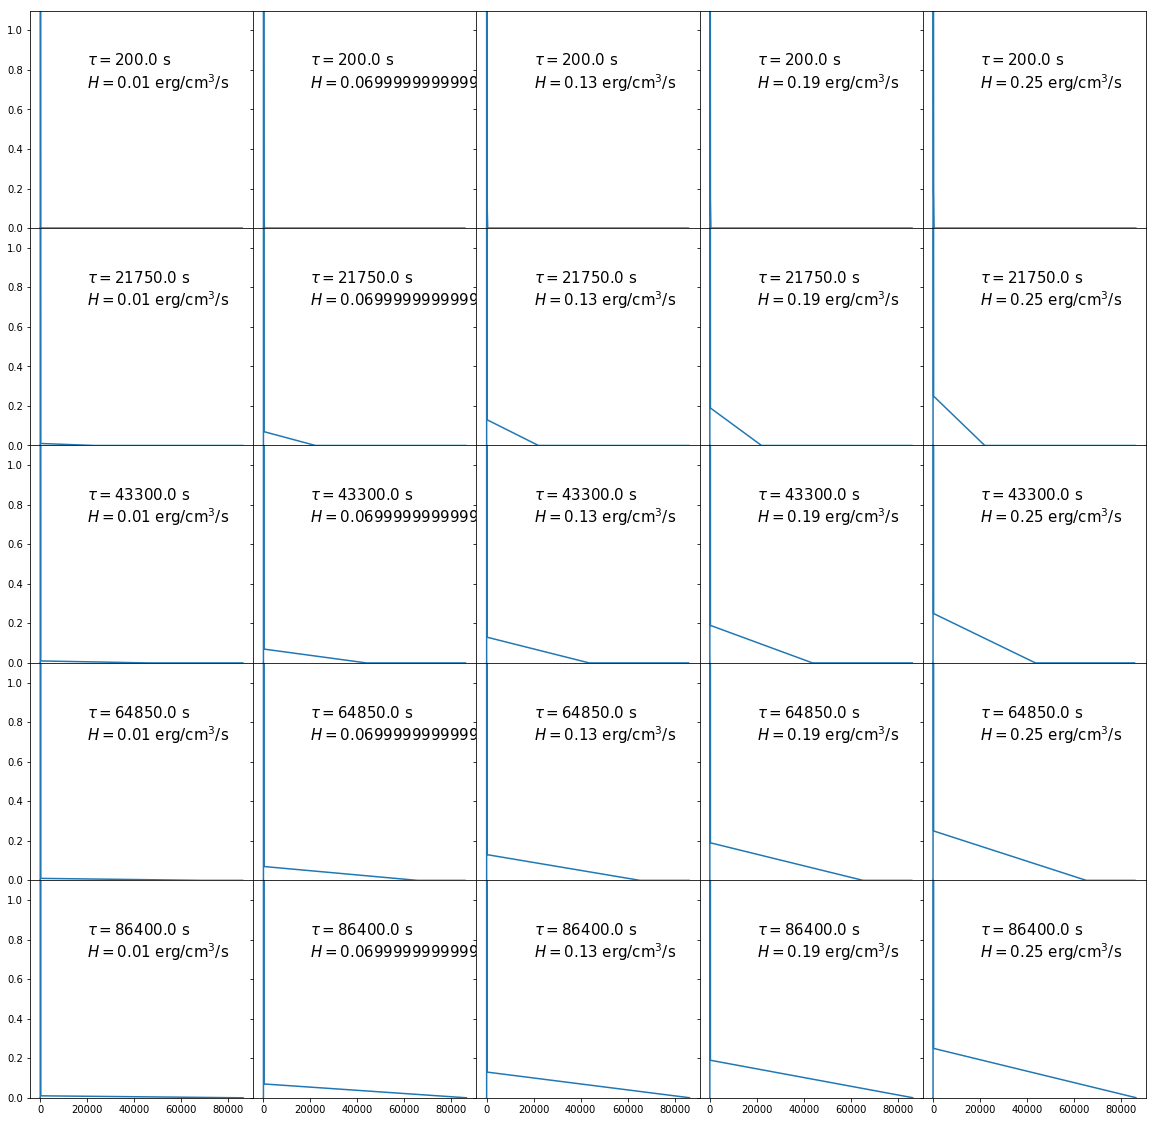

In [39]:
fig,axes = plt.subplots(duration_late.shape[0],rate_late.shape[0],figsize=(20,20),sharex=True,sharey=True)
for i,d in enumerate(duration_late):
    for j,r in enumerate(rate_late):
        ax = axes[i,j]
        res = results[f'{d}_{r}']
        ax.plot(res['t'],res['q'],color='C0')
        #ax.set_xlim(0,base_config['total_time']/10)
        ax.text(2e4,0.7,f'$\\tau={d}$ s\n$H={r}$ erg/cm$^3$/s',fontsize=15)
plt.subplots_adjust(hspace=0,wspace=0)
#plt.yscale('log')
ax.set_ylim(0,1.1)

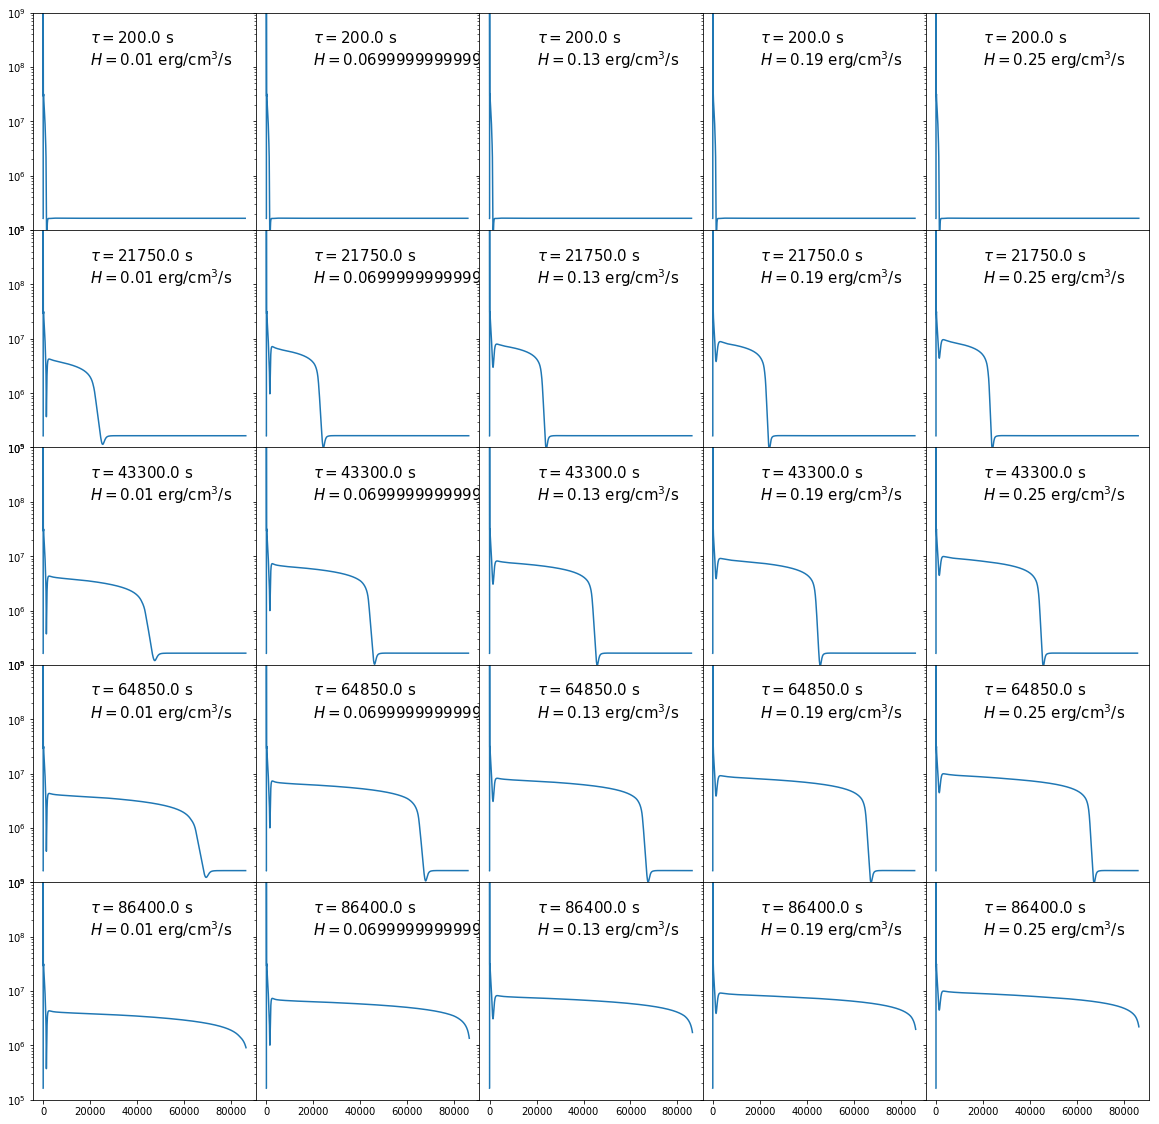

In [40]:
fig,axes = plt.subplots(duration_late.shape[0],rate_late.shape[0],figsize=(20,20),sharex=True,sharey=True)
for i,d in enumerate(duration_late):
    for j,r in enumerate(rate_late):
        ax = axes[i,j]
        res = results[f'{d}_{r}']
        ax.plot(res['t'],res['Te'],color='C0')
        #ax.set_xlim(0,base_config['total_time']/10)
        ax.set_ylim(1e5,1e9)
        ax.text(2e4,1e8,f'$\\tau={d}$ s\n$H={r}$ erg/cm$^3$/s',fontsize=15)
plt.subplots_adjust(hspace=0,wspace=0)
plt.yscale('log')

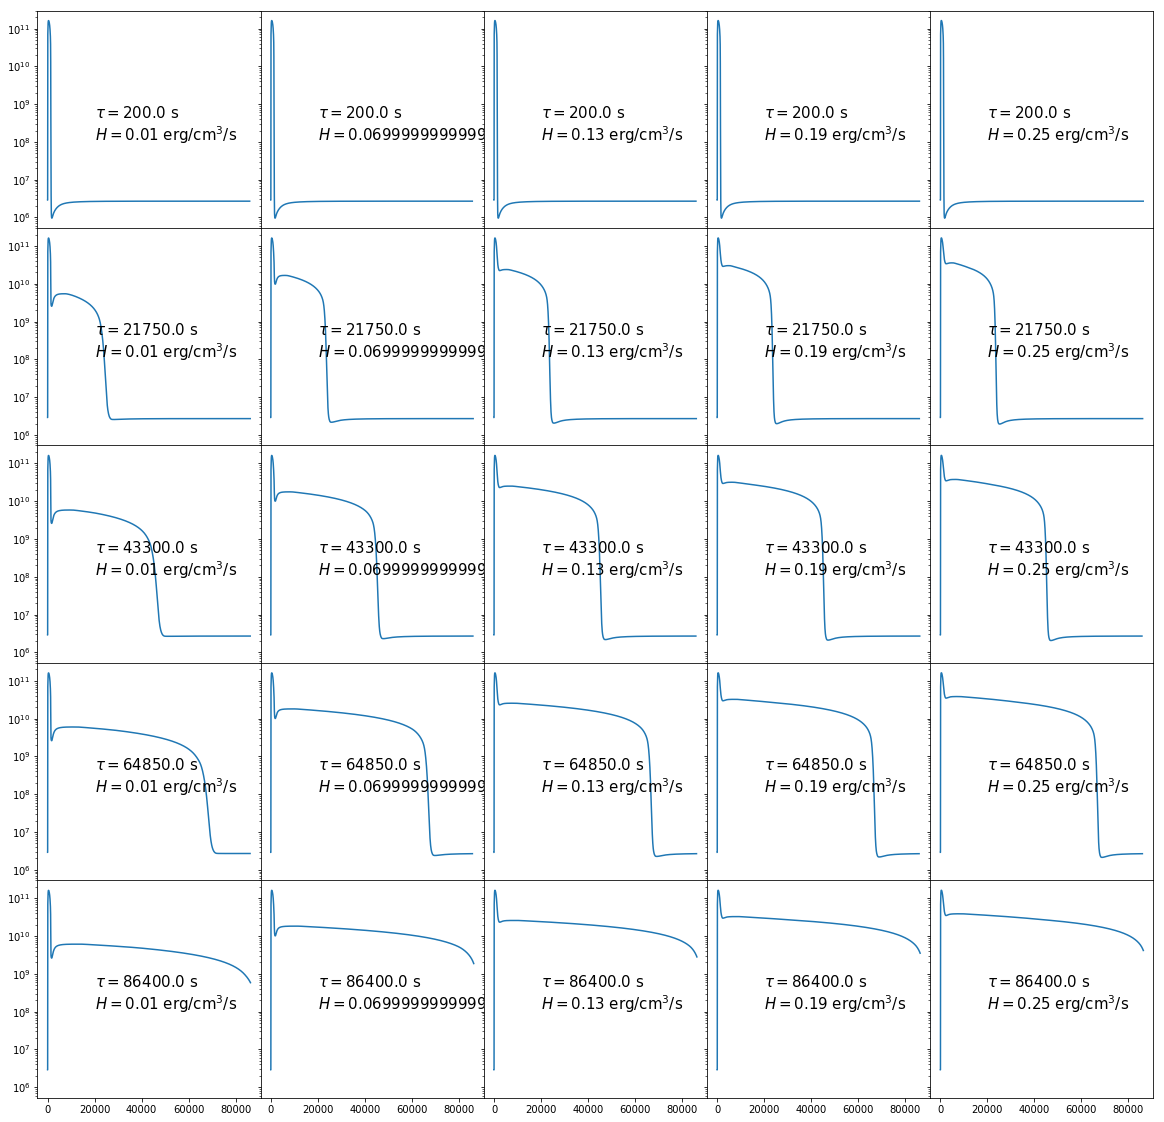

In [41]:
fig,axes = plt.subplots(duration_late.shape[0],rate_late.shape[0],figsize=(20,20),sharex=True,sharey=True)
for i,d in enumerate(duration_late):
    for j,r in enumerate(rate_late):
        ax = axes[i,j]
        res = results[f'{d}_{r}']
        ax.plot(res['t'],res['n'],color='C0')
        #ax.set_xlim(0,base_config['total_time']/10)
        #ax.set_ylim(1e5,1e9)
        ax.text(2e4,1e8,f'$\\tau={d}$ s\n$H={r}$ erg/cm$^3$/s',fontsize=15)
plt.subplots_adjust(hspace=0,wspace=0)
plt.yscale('log')

(0.1, 1000000.0)

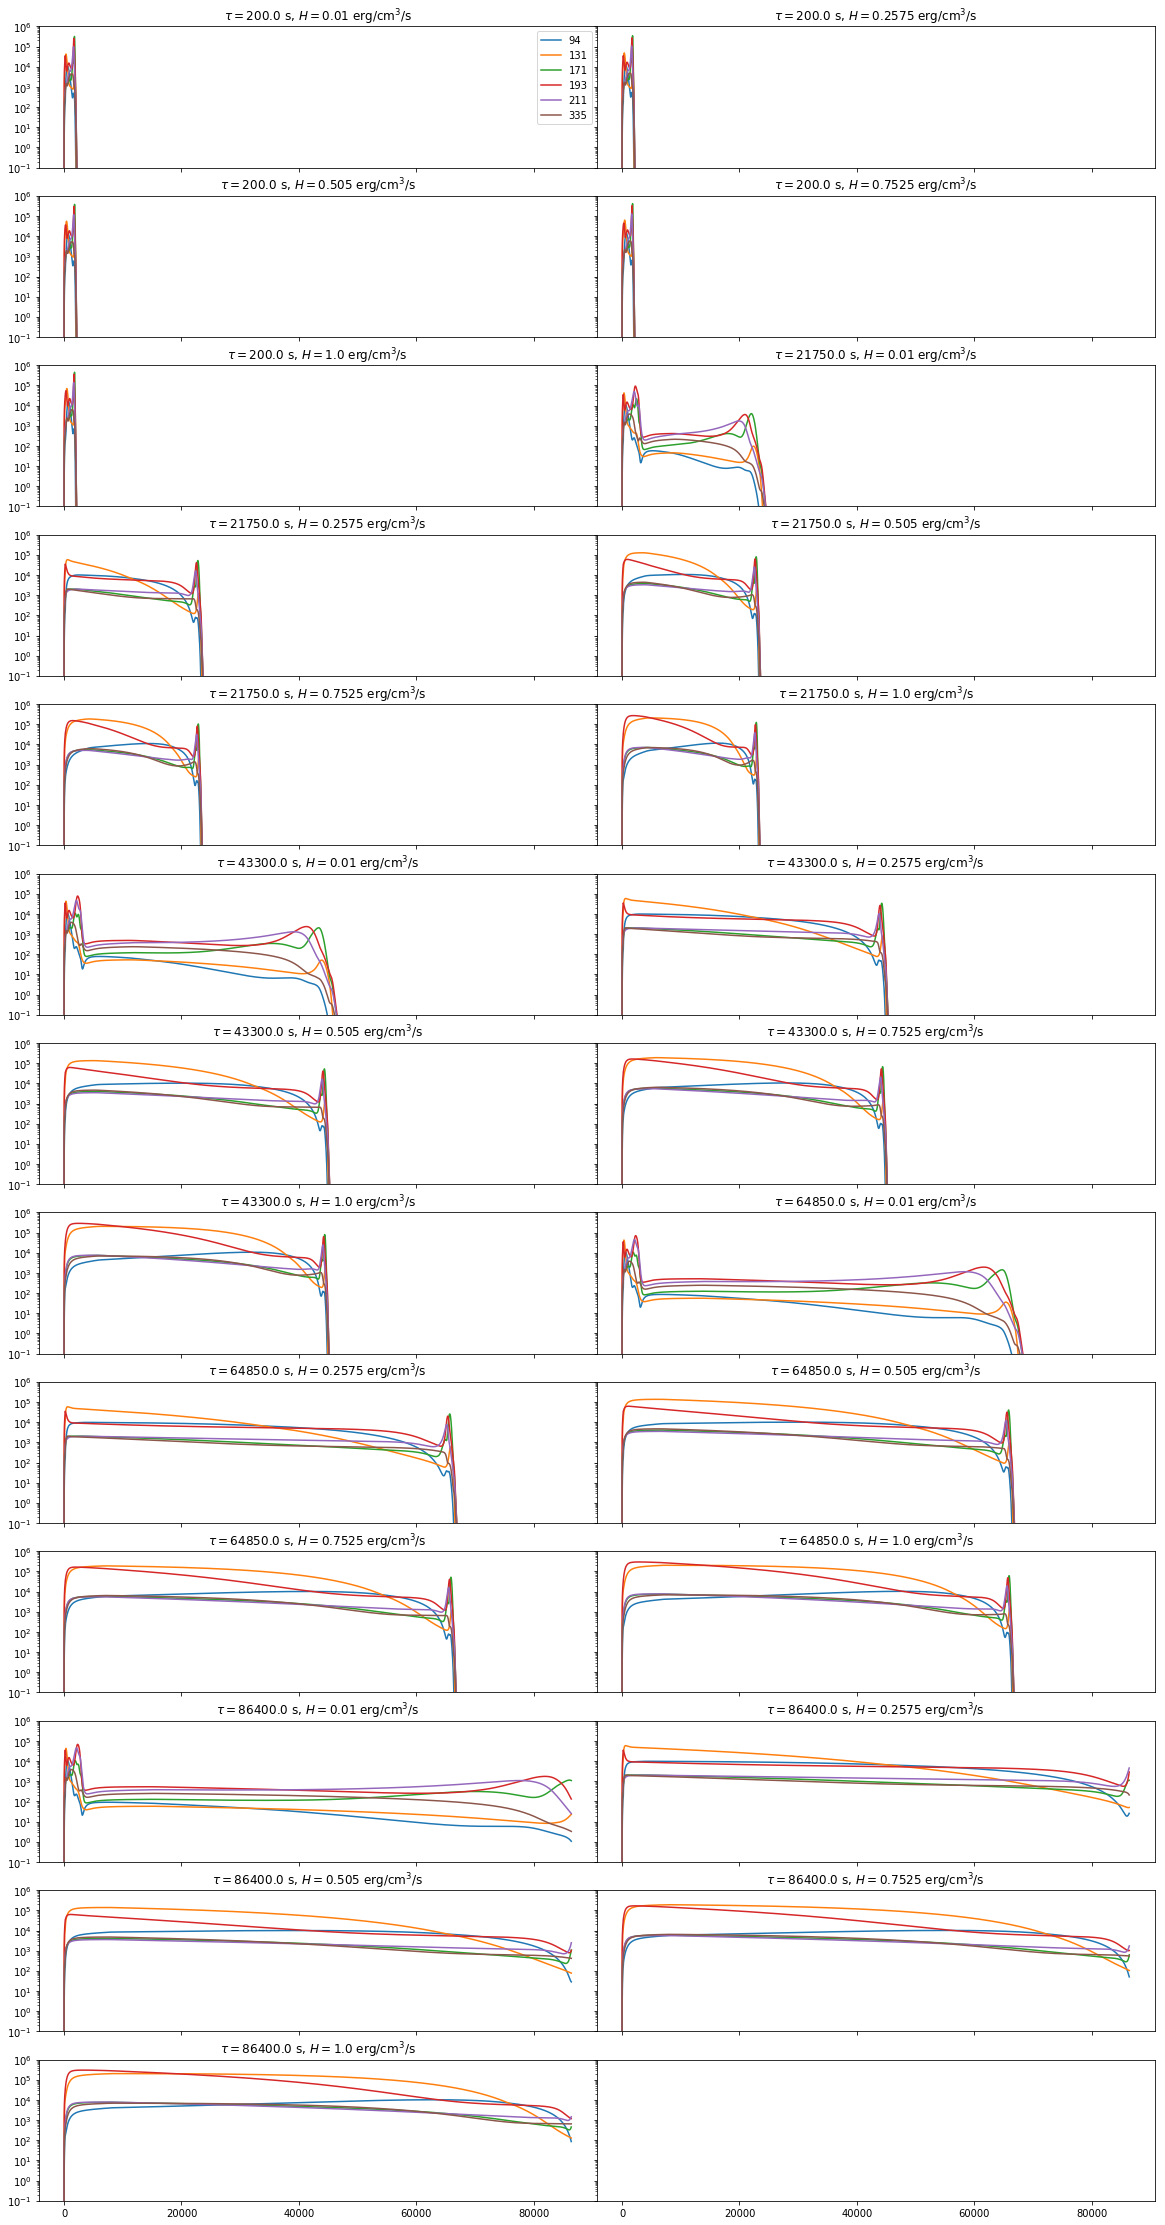

In [12]:
fig,axes = plt.subplots(13,2,figsize=(20,40),sharex=True,sharey=True)
all_combinations = [(d,r) for d in duration_late for r in rate_late]
for i,(d,r) in enumerate(all_combinations):
    ax = axes.flatten()[i]
    res = results[f'{d}_{r}']
    for k,c in enumerate(aia.channels):
        ax.plot(res['t'],res[c['name']],color=f'C{k}',label=c['name'])
    ax.set_title(f'$\\tau={d}$ s, $H={r}$ erg/cm$^3$/s',fontsize=12)
    if i == 0:
        ax.legend(loc=1)
plt.subplots_adjust(hspace=0.2,wspace=0)
ax.set_yscale('log')
ax.set_ylim(1e-1,1e6)
#ax.set_xscale('log')
#ax.set_xlim(1,base_config['total_time'])

(1e-09, 0.001)

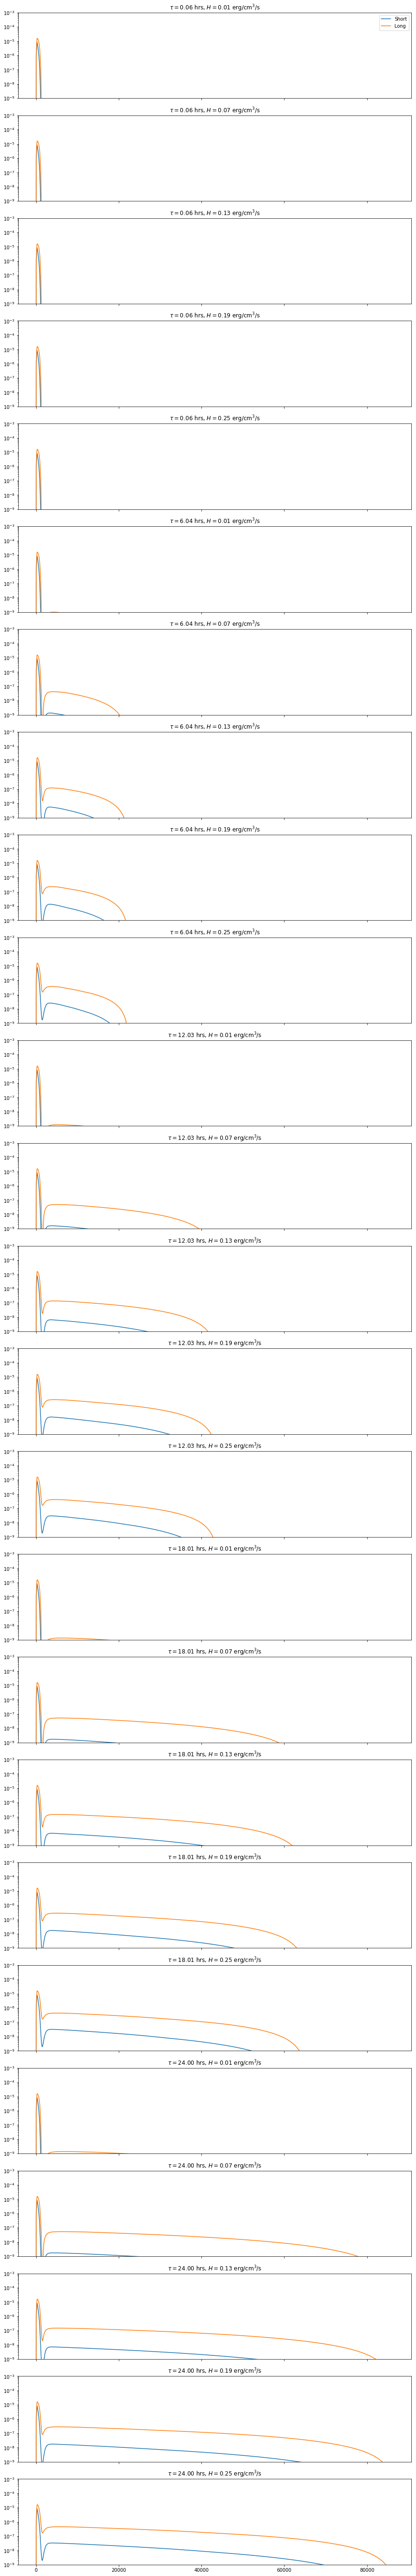

In [42]:
fig,axes = plt.subplots(25,1,figsize=(15,100),sharex=True,sharey=True)
all_combinations = [(d,r) for d in duration_late for r in rate_late]
for i,(d,r) in enumerate(all_combinations):
    ax = axes.flatten()[i]
    res = results[f'{d}_{r}']
    ax.plot(res['t'],res['goes_short'],color='C0',label='Short')
    ax.plot(res['t'],res['goes_long'],color='C1',label='Long')
    ax.set_title(f'$\\tau={(d*u.s).to(u.hour).value:.2f}$ hrs, $H={r:.2f}$ erg/cm$^3$/s',fontsize=12)
    if i == 0:
        ax.legend(loc=1)
plt.subplots_adjust(hspace=0.2,wspace=0)
ax.set_yscale('log')
ax.set_ylim(1e-9,1e-3)
#ax.set_xscale('log')
#ax.set_xlim(1,base_config['total_time'])